<a href="https://colab.research.google.com/github/christiandoramo/Variantes-para-o-epsilon/blob/main/Variantes_do_epsilon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tema 2: Variantes para o epsilon
Equipe: <br>
Christian Oliveira <br>
Raphael Barbosa <br>

Info: [Explicação do tema 2](https://docs.google.com/document/d/1bpqsUML8XkUVBMjiKMLNwbG3npgaF_35xQYrh-Dp4Ts/edit?tab=t.0#heading=h.rs93iuj1gddv )

## Configurações Iniciais

In [ ]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

### Imports Gerais

In [ ]:
import gymnasium as gym
import numpy as np

In [ ]:
from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path
from util.qtable_helper import evaluate_qtable_policy, record_video_qtable

In [ ]:
# define se os algoritmos vão imprimir dados do treinamento
VERBOSE = True

## 1. Q-Learning

Veremos aqui, vários algoritmos da família *Temporal-Difference Learning* de 1 passo. Todos eles se baseiam na em uma estimativa da função $Q(s,a)$. Porém, diferente dos Monte Carlo, eles apresendem a cada passo de interação com o episódio.

Ao invés do retorno parcial real $G_t$, todos usam uma estimativa *bootstraped* baseada nas equações de Bellamn.

Após uma experiência $(s,a,r,s')$, eles atualizam $Q$ assim:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \times (r + \gamma V(s') - Q(s,a))
$$

O método **Q-Learning** tem como característica a suposição de que, a partir de s', será executada a ação "gulosa". Assim, ele assume que um $s'$ não-terminal terá seu valor dado pela ação de melhor valor (retorno futuro a partir dela):

$$
V(s') = max_{a'}(Q(s',a'))
$$

In [ ]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def epsilon_greedy(Q, state, epsilon):
    num_actions = len(Q[state])
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])   # em caso de empates, retorna sempre o menor índice --> mais eficiente, porém...
        #return np.random.choice(np.where(Q[state] == Q[state].max())[0]) # aleatoriza em caso de empates

In [ ]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

In [ ]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.01
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo Q-Learning
rewards1, qtable1 = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Últimos resultados: media = -45.55 , desvio padrao = 67.32493965834652


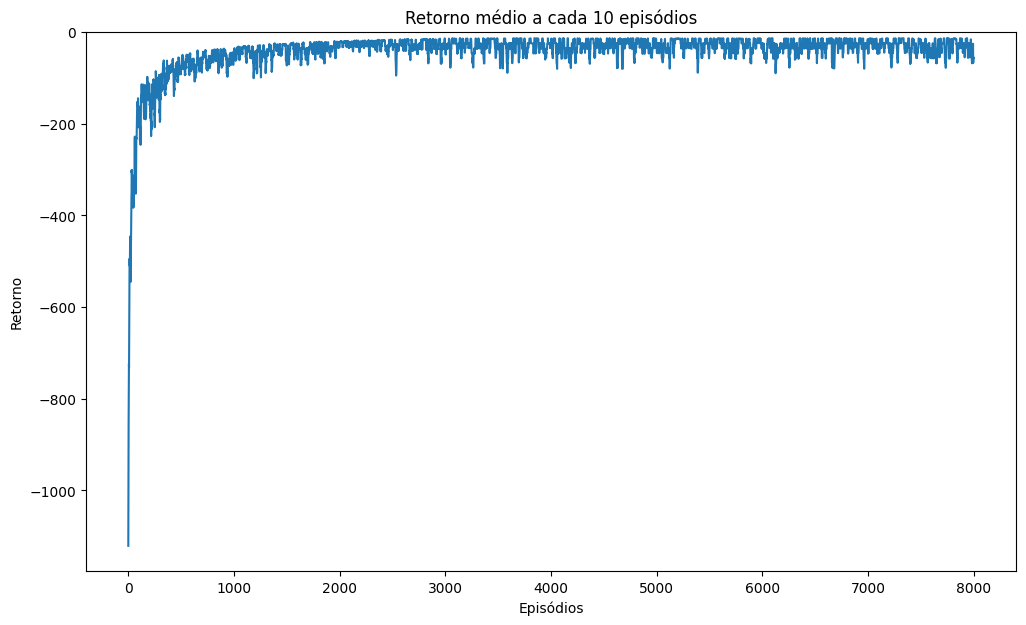

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max)

In [ ]:
# Avalia, usando a tabela de forma greedy
evaluate_qtable_policy(env, qtable1, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -13.0
Episódio 2: -13.0
Episódio 3: -13.0
Episódio 4: -13.0
Episódio 5: -13.0
Episódio 6: -13.0
Episódio 7: -13.0
Episódio 8: -13.0
Episódio 9: -13.0
Episódio 10: -13.0
Retorno médio (por episódio): -13.00, episódios: 10, total de passos: 130


In [ ]:
# Salva vídeos, usando a tabela de forma greedy
record_video_qtable(ENV_NAME, qtable1, episodes=2, folder='videos/', prefix='qlearning', epsilon=0.0)

In [ ]:
# Exibe o vídeo gravado
display_videos_from_path('videos/', prefix='qlearning')

## 2. SARSA

O **SARSA** é um algoritmo semelhante ao Q-Learning. Porém, ele usa um valor de $V(s')$ baseado na próxima ação ($a'$) realmente escolhida.

Em outras palavras, o Q-Learning:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é (guloso) baseado na melhor ação possível: $V(s') = max_{a'}{Q(s', a')}$

Porém, o SARSA:
- usa os dados $(s,a,r,s',a')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o resultado da verdadeira próxima ação $a'$: $V(s') = Q(s', a')$

Crie o código do SARSA abaixo, com base no código do Q-Learning. Dicas:
- para atualizar o $Q$, você precisa desta 4 variáveis coerentemente mantidas: `state, action, next_state, next_action`
- escolha a "próxima ação" imediatamente após cada passo (e logo após o reset) e antes da atualização do $Q$

In [ ]:
# Algoritmo SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios de -1.0 a 0.0
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon)

        while not done:
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            next_action = epsilon_greedy(Q, next_state, epsilon)

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais
                V_next_state = Q[next_state, next_action]

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action

        all_episode_rewards.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(all_episode_rewards[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return all_episode_rewards, Q

Se não conseguir implementar, descomente o código abaixo para prosseguir:

In [ ]:
#from cap05.qlearning_sarsa import run_sarsa

In [ ]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.05
GAMMA = 0.95
EPSILON = 0.05

env = gym.make(ENV_NAME, max_episode_steps=500)

# Roda o algoritmo SARSA
rewards2, qtable2 = run_sarsa(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Últimos resultados: media = -15.75 , desvio padrao = 1.1346805717910218


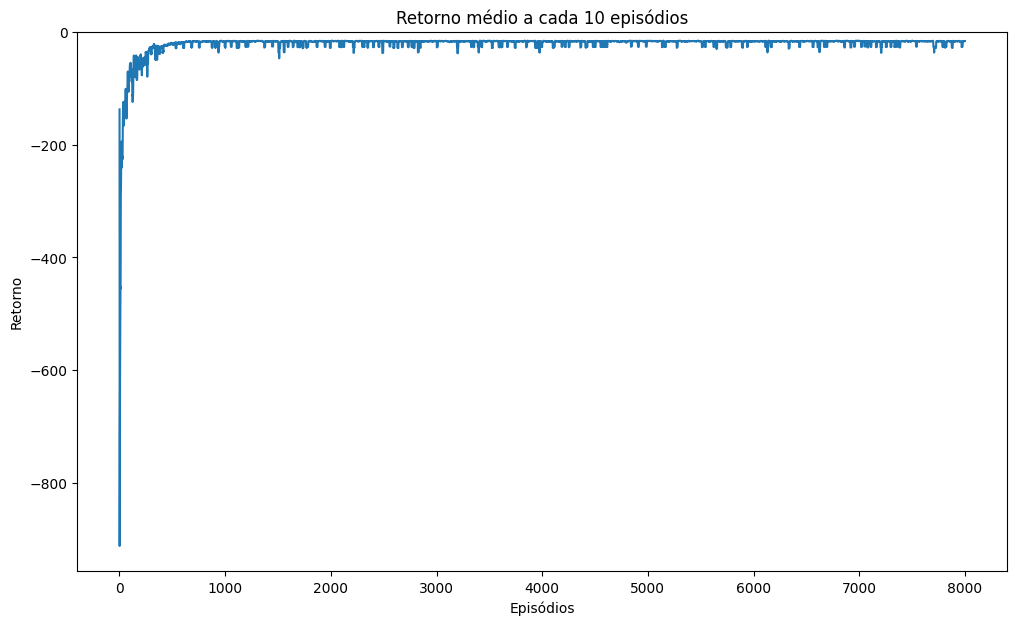

In [ ]:
plot_result(rewards2, r_max)

In [ ]:
evaluate_qtable_policy(env, qtable2, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -15.0
Episódio 2: -15.0
Episódio 3: -15.0
Episódio 4: -15.0
Episódio 5: -15.0
Episódio 6: -15.0
Episódio 7: -15.0
Episódio 8: -15.0
Episódio 9: -15.0
Episódio 10: -15.0
Retorno médio (por episódio): -15.00, episódios: 10, total de passos: 150


In [ ]:
record_video_qtable(ENV_NAME, qtable2, episodes=2, folder='videos/', prefix='sarsa', epsilon=0.0)
#clear_output()

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
display_videos_from_path('videos/', prefix='sarsa')

## 3. Expected-SARSA

O Expected-SARSA tem semelhanças com os dois algoritmos vistos antes:
- usa os dados $(s,a,r,s')$ para fazer uma atualização no $Q(s,a)$
- assume que o valor do próximo estado é o valor médio, com base nas probabilidades dadas pela política:
   $$V(s') = \displaystyle\sum_{a'} \pi(a'|s') \times Q(s',a')$$

Para implementá-lo, precisamos das probabilidades da política realizar cada ação.

A função abaixo retorna as probabilidades de cada ação na política *epsilon-greedy*:

In [ ]:
def epsilon_greedy_probs(Q, state, num_actions, epsilon):
    # lista com a probabilidade que todas as ações têm de ser escolhidas nas decisões exploratórias (não-gulosas)
    probs = [ (epsilon / num_actions) ] * num_actions

    # adiciona a probabilidade para a ação 'greedy'
    # em caso de empate, só o menor índice é considerado
    # (isso é coerente com a implementação da função epsilon_greedy())
    greedy_action = np.argmax(Q[state])
    probs[greedy_action] += (1.0 - epsilon)

    return probs

In [ ]:
# Algoritmo Expected-SARSA
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    num_actions = env.action_space.n

    # inicializa a tabela Q toda com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, trunc, _ = env.step(action)
            done = terminated or trunc

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                p_next_actions = epsilon_greedy_probs(Q, next_state, num_actions, epsilon)
                V_next_state = np.sum( np.asarray(p_next_actions) * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return sum_rewards_per_ep, Q


In [ ]:
#ENV_NAME, r_max = "Taxi-v3", 10
ENV_NAME, r_max = "CliffWalking-v0", 0

EPISODES = 8_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1

env = gym.make(ENV_NAME, max_episode_steps=500)

rewards3, qtable3 = run_expected_sarsa(env, EPISODES, LR, GAMMA, EPSILON)
clear_output()

print("Últimos resultados: media =", np.mean(rewards3[-20:]), ", desvio padrao =", np.std(rewards3[-20:]))

Últimos resultados: media = -16.6 , desvio padrao = 1.3190905958272918


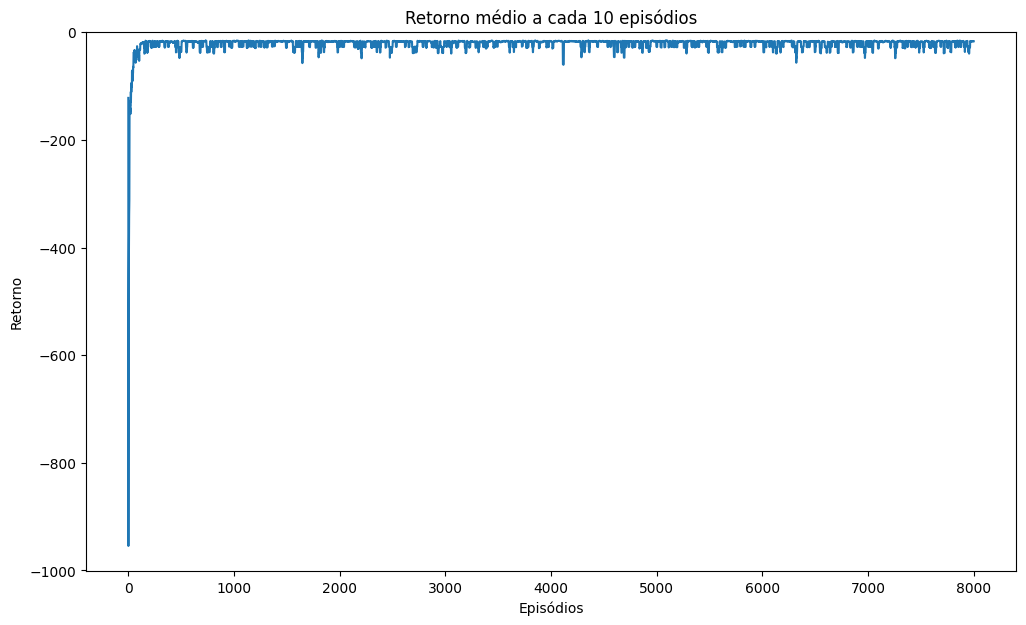

In [ ]:
plot_result(rewards3, r_max)

In [ ]:
evaluate_qtable_policy(env, qtable3, num_episodes=10, epsilon=0.0, verbose=True);

Episódio 1: -15.0
Episódio 2: -15.0
Episódio 3: -15.0
Episódio 4: -15.0
Episódio 5: -15.0
Episódio 6: -15.0
Episódio 7: -15.0
Episódio 8: -15.0
Episódio 9: -15.0
Episódio 10: -15.0
Retorno médio (por episódio): -15.00, episódios: 10, total de passos: 150


In [ ]:
record_video_qtable(ENV_NAME, qtable3, episodes=2, folder='videos/', prefix='expec-sarsa', epsilon=0.0)
clear_output()

In [ ]:
display_videos_from_path('videos/', prefix='expec-sarsa')

In [ ]:
## 4. Experimentos

In [ ]:
# parâmetros para todos os algoritmos (não é o ideal)
LR = 0.1
GAMMA = 0.95
EPSILON = 0.05

# silencia os algoritmos
VERBOSE = False

# repetições de cada algoritmo
RUNS = 5

# para carregar automaticamente os resultados de simulações já executadas
AUTO_LOAD = False

### Taxi-v3 (discreto)

In [ ]:
environment = gym.make("Taxi-v3")
NUM_EPISODES = 5_000

results_t = []

results_t.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_t.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_t.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

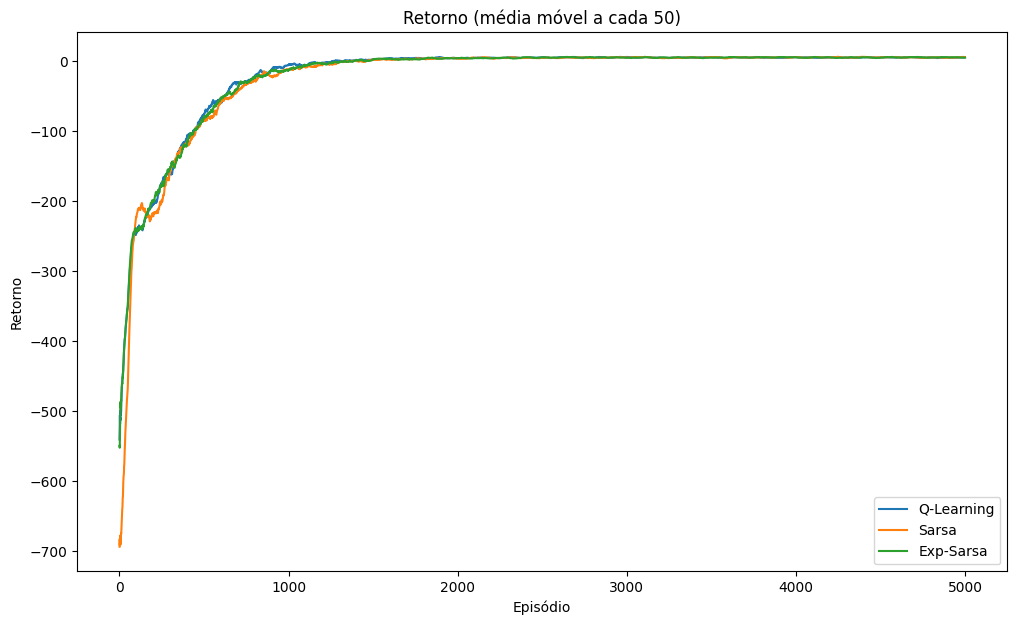

In [ ]:
plot_multiple_results(results_t, x_log_scale=False, window=50)

### FrozenLake-v1

In [ ]:
environment = gym.make("FrozenLake-v1")
NUM_EPISODES = 8_000

results_f = []

results_f.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_f.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_f.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

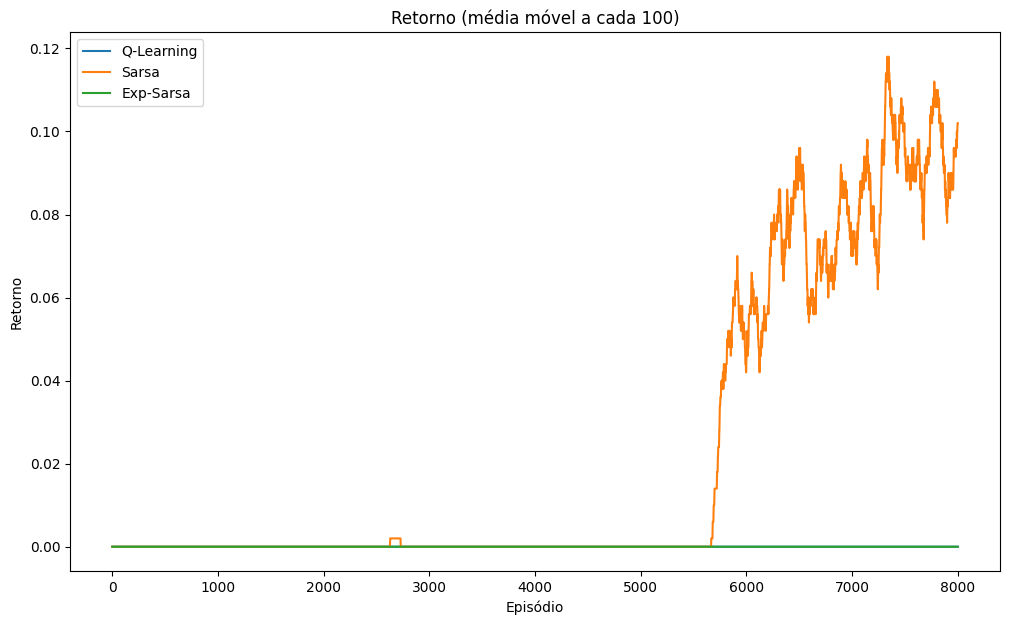

In [ ]:
plot_multiple_results(results_f, x_log_scale=False, window=100)

### Cliff Walking

In [ ]:
environment = gym.make("CliffWalking-v0", max_episode_steps=100)
NUM_EPISODES = 1_000

results_c = []

results_c.append( repeated_exec(RUNS, f"Q-Learning", run_qlearning, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_c.append( repeated_exec(RUNS, f"Sarsa", run_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()
results_c.append( repeated_exec(RUNS, f"Exp-Sarsa", run_expected_sarsa, environment, NUM_EPISODES, LR, GAMMA, EPSILON, auto_load=AUTO_LOAD) )
clear_output()

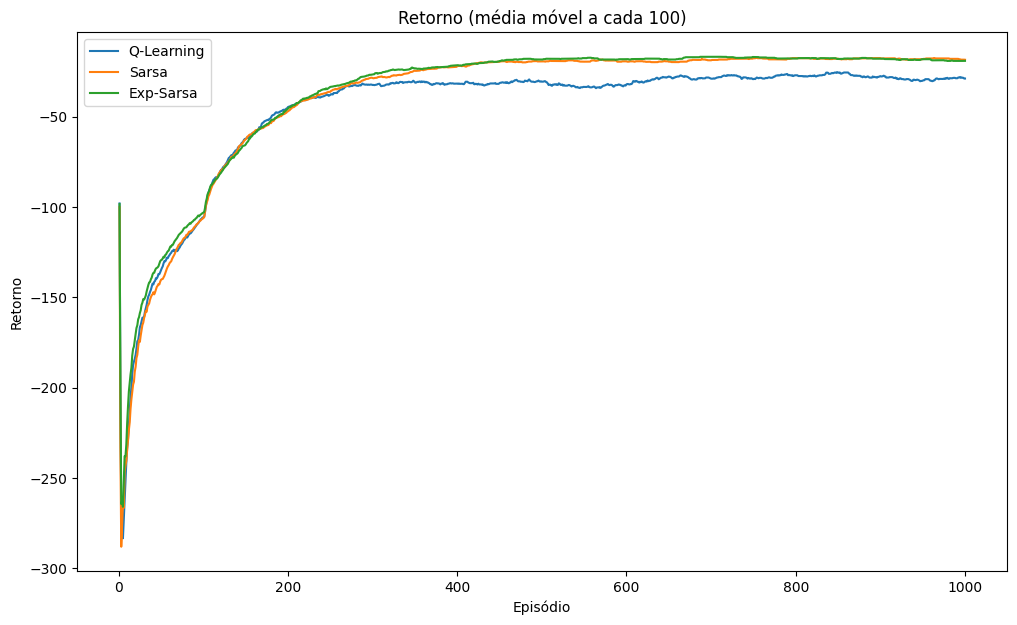

In [ ]:
plot_multiple_results(results_c, x_log_scale=False, window=100)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main.ipynb)

# Capítulo 6 - SARSA de _n_ passos / Tratando Estados Contínuos


## Configurações Iniciais

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

import numpy as np

from cap06.nstep_sarsa import run_nstep_sarsa

from envs import RacetrackEnv
from envs.wrappers import ObservationDiscretizerWrapper


## 1 - SARSA de n Passos

É uma extensão do SARSA que usa uma sequência de de *n* passos (ou seja, com *n* ações realizadas no ambiente) como entrada para cada atualização da estimativa do $Q(s,a)$.

Com **$n=1$**, ele estima $Q(s,a)$ igual ao *SARSA*:
- usa esta experiência: $s, a, r_1, s_1, a_1$
- calcula a nova estimativa de $Q(s,a)$ assim (para estados não-terminais):
$$Q_{target} = r_1 + \gamma . Q(s_1,a_1)$$
- note que apenas 1 ação foi realizada ($a$) e apenas 1 recompensa foi recebida ($r_1$)
- observe que a última ação ($a_1$) foi escolhida, mas não foi realizada no ambiente

Com **$n=2$**, para estimar $Q(s,a)$, ele:
- usa esta experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2$
- calcula a nova estimativa de $Q(s,a)$ assim:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . Q(s_2,a_2)$$
- esta é uma estimativa mais precisa, que usa os dados de *duas* recompensas reais

Para **$n$ qualquer**:
- experiência: $s, a, r_1, s_1, a_1, r_2, s_2, a_2, s_3, \cdots, r_n, s_n, a_n$
- nova estimativa:
$$Q_{target} = r_1 + \gamma .r_2 + \gamma^2 . r_2 + \cdots + \gamma^n . Q(s_n,a_n)$$

O $n$ será um parâmetro do algoritmo.

O código é mais complexo do que dos algoritmos de 1 passo. Veja o arquivo `cap06/nstep_sarsa.py` para conhecer os detalhes.

Abaixo, vamos importar e usar aquela implementação para fazer um experimento:

In [ ]:
# para ambientes gymnasium
#ENV_NAME, r_max = "Taxi-v3", 10
#ENV_NAME, r_max = "CliffWalking-v0", 0
#ENV_NAME, r_max = "FrozenLake-v1", 0
ENV_NAME, r_max = "RaceTrack-v0", 0

env = gym.make(ENV_NAME)

# para ambientes instanciados diretamente
# atenção: vale a pena aplicar um TimeLimit
#env = RacetrackEnv()
#r_max = 0

EPISODES = 5_000
LR = 0.1
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 5

# Roda o algoritmo "n-step SARSA"
rewards1, qtable1 = run_nstep_sarsa(env, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Episode 100 Average Reward (last 100): -117.700
Episode 200 Average Reward (last 100): -107.360
Episode 300 Average Reward (last 100): -98.170
Episode 400 Average Reward (last 100): -92.680
Episode 500 Average Reward (last 100): -90.890
Episode 600 Average Reward (last 100): -82.750
Episode 700 Average Reward (last 100): -77.380
Episode 800 Average Reward (last 100): -78.120
Episode 900 Average Reward (last 100): -72.350
Episode 1000 Average Reward (last 100): -61.510
Episode 1100 Average Reward (last 100): -67.640
Episode 1200 Average Reward (last 100): -63.720
Episode 1300 Average Reward (last 100): -54.710
Episode 1400 Average Reward (last 100): -60.050
Episode 1500 Average Reward (last 100): -52.550
Episode 1600 Average Reward (last 100): -56.060
Episode 1700 Average Reward (last 100): -58.030
Episode 1800 Average Reward (last 100): -45.170
Episode 1900 Average Reward (last 100): -47.590
Episode 2000 Average Reward (last 100): -50.230
Episode 2100 Average Reward (last 100): -47.150

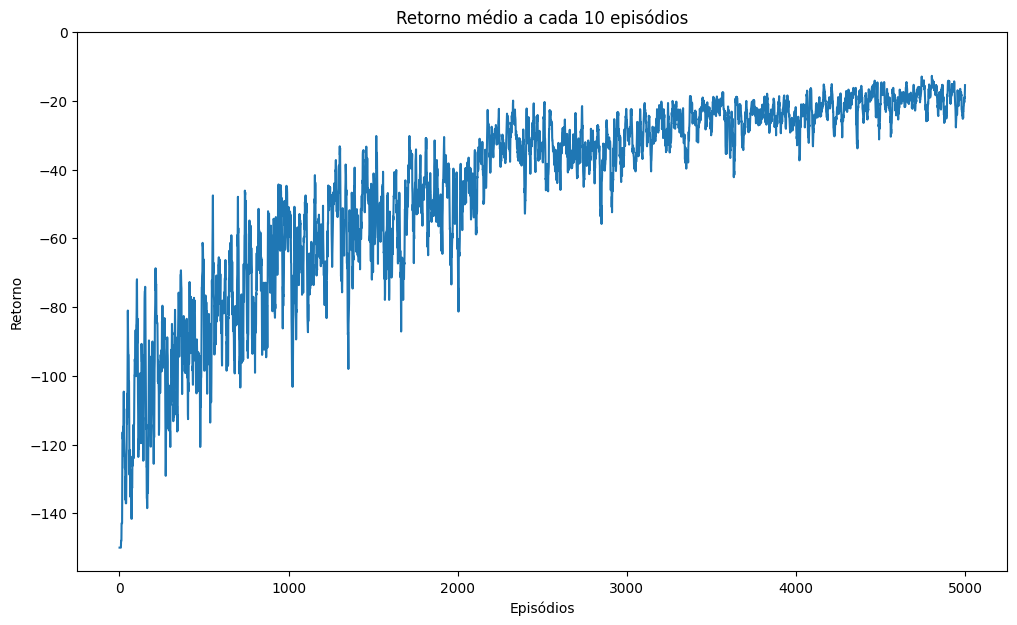

In [ ]:
# Mostra um gráfico de episódios x retornos não descontados
plot_result(rewards1, r_max, None)

In [ ]:
evaluate_qtable_policy(env, qtable1, 10, epsilon=0.1, verbose=True);

Episódio 1: -20.0
Episódio 2: -25.0
Episódio 3: -13.0
Episódio 4: -20.0
Episódio 5: -13.0
Episódio 6: -34.0
Episódio 7: -41.0
Episódio 8: -29.0
Episódio 9: -19.0
Episódio 10: -17.0
Retorno médio (por episódio): -23.10, episódios: 10, total de passos: 241


In [ ]:
# atenção: precisa passar a ID do ambiente no gymnasium ou instanciar diretamente um novo ambiente com o render_mode "rgb_array"
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')
#record_video_qtable(RacetrackEnv(render_mode="rgb_array"), qtable1, episodes=3, folder='videos/', prefix='nstep-discrete')

In [ ]:
display_videos_from_path('./videos', prefix='nstep-discrete')

A seguir, vamos rodar alguns experimentos variando a quantidade de passos:

In [ ]:
RUNS = 3
results1 = []
for nstep in [1, 2, 3]:
    results1.append( repeated_exec(RUNS, f"{nstep}-step SARSA (LR={LR})", run_nstep_sarsa, env, EPISODES, nstep, LR) )
    clear_output()

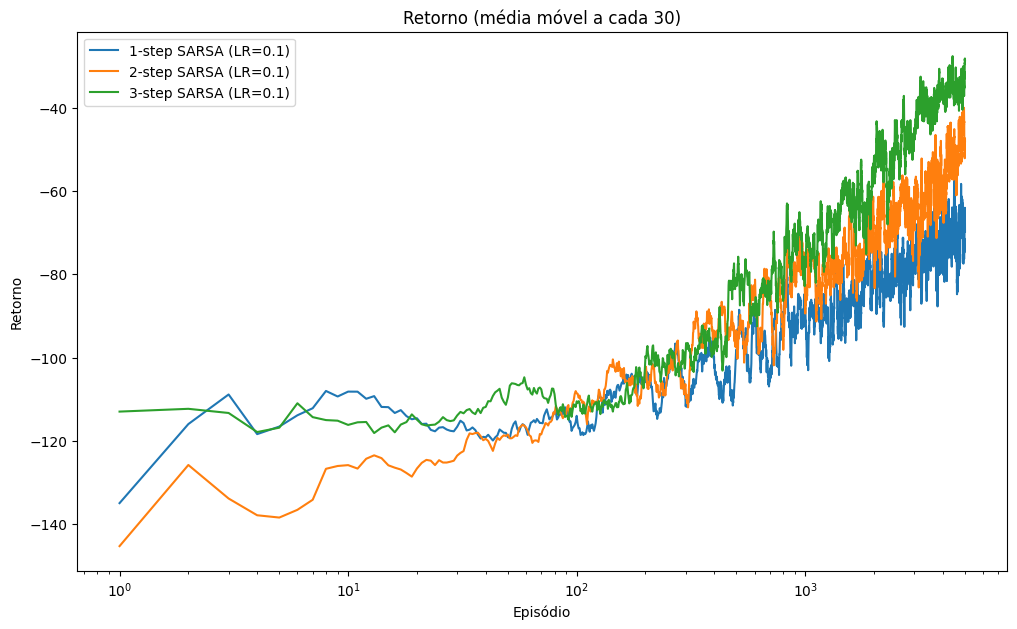

In [ ]:
plot_multiple_results(results1, window=30, x_log_scale=True)

## 2 - Lidando com Estados Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes de estados contínuos.

Para isso, vamos usar um *wrapper* que discretiza os estados desses ambientes.

Primeiramente, vamos analisar, abaixo, o espaço de estados de um ambiente contínuo:

In [ ]:
ENV_NAME = "CartPole-v1"
r_max_plot = 200

env2a = gym.make(ENV_NAME)

# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env2a.observation_space)
print("  - formato: ", env2a.observation_space.shape)
print("  - exemplo: ", env2a.reset())

Espaço de estados/observações:  Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  - formato:  (4,)
  - exemplo:  (array([-0.04109067, -0.01078413,  0.04797613,  0.02560637], dtype=float32), {})


Abaixo, nós encapsulamos o ambiente contínuo em um wrapper para discretizá-lo.

Os parâmetros indicam quantos valores discretos foram usados para representar cada uma das dimensões do estado.

Como resultado, o espaço de estados torna-se do tipo `Discrete`, o que indica que cada "estado" é representado como um único número inteiro.

In [ ]:
# Encapsula o ambiente em nosso wrapper
# atenção para o parâmetro BINS: deve ter um valor para cada componente do estado
BINS = [5, 30, 30, 30]
env2b = ObservationDiscretizerWrapper(env2a, BINS)

env2b.observation_space

/content/rl_facil/envs/wrappers.py:57: RuntimeWarning: overflow encountered in scalar multiply
  min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


Discrete(135000)

Agora, podemos rodar treinamentos com quaisquer dos algoritmos que temos visto. Vamos rodar o *SARSA de n passos*:

In [ ]:
EPISODES = 5_000
LR = 0.2
GAMMA = 0.95
EPSILON = 0.1
NSTEPS = 4

rewards2, qtable2 = run_nstep_sarsa(env2b, EPISODES, NSTEPS, LR, GAMMA, EPSILON, verbose=True)

print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Episode 100 Average Reward (last 100): 12.960
Episode 200 Average Reward (last 100): 22.890
Episode 300 Average Reward (last 100): 22.510
Episode 400 Average Reward (last 100): 27.220
Episode 500 Average Reward (last 100): 37.530
Episode 600 Average Reward (last 100): 33.990
Episode 700 Average Reward (last 100): 35.430
Episode 800 Average Reward (last 100): 36.640
Episode 900 Average Reward (last 100): 36.210
Episode 1000 Average Reward (last 100): 35.060
Episode 1100 Average Reward (last 100): 40.060
Episode 1200 Average Reward (last 100): 34.170
Episode 1300 Average Reward (last 100): 37.740
Episode 1400 Average Reward (last 100): 33.360
Episode 1500 Average Reward (last 100): 34.110
Episode 1600 Average Reward (last 100): 36.670
Episode 1700 Average Reward (last 100): 36.740
Episode 1800 Average Reward (last 100): 38.860
Episode 1900 Average Reward (last 100): 38.070
Episode 2000 Average Reward (last 100): 36.920
Episode 2100 Average Reward (last 100): 38.230
Episode 2200 Average R

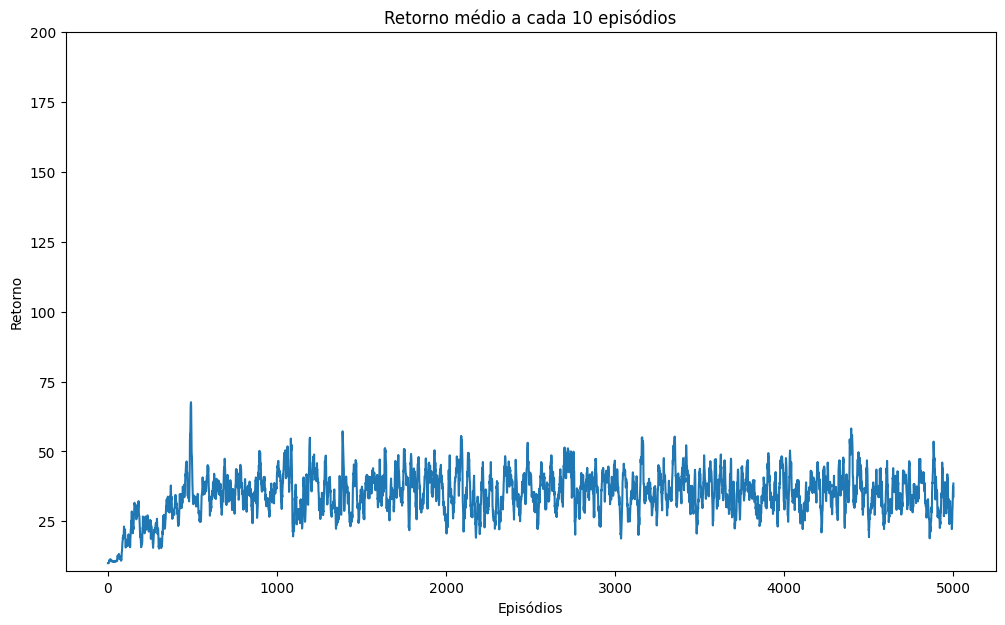

In [ ]:
# Gera um gráfico de episódios x retornos (não descontados)
plot_result(rewards2, r_max_plot)

In [ ]:
# Faz alguns testes, usando a tabela de forma greedy
evaluate_qtable_policy(env2b, qtable2, 10, 0.0, verbose=True)

Episódio 1: 57.0
Episódio 2: 35.0
Episódio 3: 40.0
Episódio 4: 40.0
Episódio 5: 36.0
Episódio 6: 56.0
Episódio 7: 39.0
Episódio 8: 39.0
Episódio 9: 43.0
Episódio 10: 39.0
Retorno médio (por episódio): 42.40, episódios: 10, total de passos: 424


(42.4, [57.0, 35.0, 40.0, 40.0, 36.0, 56.0, 39.0, 39.0, 43.0, 39.0])

In [ ]:
# Salva vídeo
# Atenção: é recomendado criar nova instância do ambiente e do wrapper!
env_test = gym.make(ENV_NAME, render_mode="rgb_array")
env_test = ObservationDiscretizerWrapper(env_test, BINS)
record_video_qtable(env_test, qtable2, episodes=3, folder='videos/', prefix='nstep-cartpole')

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Exibe o video
display_videos_from_path('./videos', prefix='nstep-cartpole')

## 3 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [ ]:
import optuna

### 3.1 - Ambiente Discreto

Este é o caso mais simples, porque não precisamos aplicar nenhum wrapper.

Primeiro, você precisa fazer uma função que receber um parâmetro do tipo `Trial` (definido no optuna) e retorna uma medida de desempenho.

Dentro da função, você usa o objeto *trial* para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [ ]:
def train_nstep_sarsa_racetrack(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    gamma  = trial.suggest_float('gamma', 0.90, 1.00)
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # outra opção trial.suggest_categorical('param', ['value1', 'value2'])

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente Racetrack, mas insere-o em um wrapper para limitar o tamanho do episódio
    env = gym.make("RaceTrack-v0")

    # roda o algoritmo e recebe os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env, 3000, nsteps, lr=lr, epsilon=eps, gamma=gamma, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


Depois, você cria um "study" do Optuna e manda otimizar sua função, indicando quantas tentativas (trials) ele vai fazer -- ou seja, quantas vezes a sua função vai ser executada.

In [ ]:
study1 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_racetrack',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa, rodando "n_trials" vezes
# o parâmetro "n_jobs" indica a quantidade de CPUs a serem usadas (-1 para usar todas)
study1.optimize(train_nstep_sarsa_racetrack, n_trials=20, n_jobs=2)

[I 2025-02-12 22:01:28,016] A new study created in RDB with name: nstep_sarsa_racetrack



TRIAL #0: {'epsilon': 0.07281237718512752, 'gamma': 0.9969211542849417, 'lr': 0.011201882232462237, 'nsteps': 8}

TRIAL #1: {'epsilon': 0.13604760789175568, 'gamma': 0.9616497242102604, 'lr': 0.31261664511098597, 'nsteps': 1}


[I 2025-02-12 22:01:56,058] Trial 1 finished with value: -60.46 and parameters: {'epsilon': 0.13604760789175568, 'gamma': 0.9616497242102604, 'lr': 0.31261664511098597, 'nsteps': 1}. Best is trial 1 with value: -60.46.



TRIAL #2: {'epsilon': 0.13072581950001522, 'gamma': 0.9041389995852054, 'lr': 0.0020881036349394574, 'nsteps': 2}


[I 2025-02-12 22:02:00,671] Trial 0 finished with value: -68.49 and parameters: {'epsilon': 0.07281237718512752, 'gamma': 0.9969211542849417, 'lr': 0.011201882232462237, 'nsteps': 8}. Best is trial 1 with value: -60.46.



TRIAL #3: {'epsilon': 0.05669254848600553, 'gamma': 0.9388773382506408, 'lr': 0.0026400698130071595, 'nsteps': 16}


[I 2025-02-12 22:02:32,877] Trial 2 finished with value: -97.9 and parameters: {'epsilon': 0.13072581950001522, 'gamma': 0.9041389995852054, 'lr': 0.0020881036349394574, 'nsteps': 2}. Best is trial 1 with value: -60.46.



TRIAL #4: {'epsilon': 0.012405238814833363, 'gamma': 0.9049692072265227, 'lr': 0.6234319445974196, 'nsteps': 14}


[I 2025-02-12 22:02:36,925] Trial 3 finished with value: -75.12 and parameters: {'epsilon': 0.05669254848600553, 'gamma': 0.9388773382506408, 'lr': 0.0026400698130071595, 'nsteps': 16}. Best is trial 1 with value: -60.46.



TRIAL #5: {'epsilon': 0.1263167813681056, 'gamma': 0.989815130398166, 'lr': 0.07673956805132073, 'nsteps': 10}


[I 2025-02-12 22:02:44,086] Trial 4 finished with value: -15.29 and parameters: {'epsilon': 0.012405238814833363, 'gamma': 0.9049692072265227, 'lr': 0.6234319445974196, 'nsteps': 14}. Best is trial 4 with value: -15.29.



TRIAL #6: {'epsilon': 0.19555504551259553, 'gamma': 0.9452402553378529, 'lr': 0.004679800550115365, 'nsteps': 2}


[I 2025-02-12 22:02:58,062] Trial 5 finished with value: -20.18 and parameters: {'epsilon': 0.1263167813681056, 'gamma': 0.989815130398166, 'lr': 0.07673956805132073, 'nsteps': 10}. Best is trial 4 with value: -15.29.



TRIAL #7: {'epsilon': 0.15786563881888835, 'gamma': 0.9626140770382584, 'lr': 0.11544965403878342, 'nsteps': 2}


[I 2025-02-12 22:03:22,780] Trial 6 finished with value: -101.89 and parameters: {'epsilon': 0.19555504551259553, 'gamma': 0.9452402553378529, 'lr': 0.004679800550115365, 'nsteps': 2}. Best is trial 4 with value: -15.29.



TRIAL #8: {'epsilon': 0.10922152498699482, 'gamma': 0.9112067318092107, 'lr': 0.0022500381133944013, 'nsteps': 14}


[I 2025-02-12 22:03:27,555] Trial 7 finished with value: -61.11 and parameters: {'epsilon': 0.15786563881888835, 'gamma': 0.9626140770382584, 'lr': 0.11544965403878342, 'nsteps': 2}. Best is trial 4 with value: -15.29.



TRIAL #9: {'epsilon': 0.0523417371795052, 'gamma': 0.9952033912236311, 'lr': 0.0018293038912885785, 'nsteps': 10}


[I 2025-02-12 22:03:56,340] Trial 8 finished with value: -88.45 and parameters: {'epsilon': 0.10922152498699482, 'gamma': 0.9112067318092107, 'lr': 0.0022500381133944013, 'nsteps': 14}. Best is trial 4 with value: -15.29.



TRIAL #10: {'epsilon': 0.16058617426532246, 'gamma': 0.9047655365517978, 'lr': 0.03939935547331144, 'nsteps': 12}


[I 2025-02-12 22:04:03,681] Trial 9 finished with value: -78.23 and parameters: {'epsilon': 0.0523417371795052, 'gamma': 0.9952033912236311, 'lr': 0.0018293038912885785, 'nsteps': 10}. Best is trial 4 with value: -15.29.



TRIAL #11: {'epsilon': 0.010596577112934305, 'gamma': 0.9246262909091492, 'lr': 0.9434742170112828, 'nsteps': 13}


[I 2025-02-12 22:04:18,587] Trial 11 finished with value: -17.13 and parameters: {'epsilon': 0.010596577112934305, 'gamma': 0.9246262909091492, 'lr': 0.9434742170112828, 'nsteps': 13}. Best is trial 4 with value: -15.29.



TRIAL #12: {'epsilon': 0.0123613221083389, 'gamma': 0.9245573557876567, 'lr': 0.7640772581689959, 'nsteps': 13}


[I 2025-02-12 22:04:23,375] Trial 10 finished with value: -49.85 and parameters: {'epsilon': 0.16058617426532246, 'gamma': 0.9047655365517978, 'lr': 0.03939935547331144, 'nsteps': 12}. Best is trial 4 with value: -15.29.



TRIAL #13: {'epsilon': 0.010615796219303307, 'gamma': 0.9251291085064007, 'lr': 0.974089628373259, 'nsteps': 16}


[I 2025-02-12 22:04:30,321] Trial 12 finished with value: -13.53 and parameters: {'epsilon': 0.0123613221083389, 'gamma': 0.9245573557876567, 'lr': 0.7640772581689959, 'nsteps': 13}. Best is trial 12 with value: -13.53.



TRIAL #14: {'epsilon': 0.018537053795441558, 'gamma': 0.9266967426326748, 'lr': 0.8878198955242224, 'nsteps': 16}


[I 2025-02-12 22:04:36,087] Trial 13 finished with value: -18.3 and parameters: {'epsilon': 0.010615796219303307, 'gamma': 0.9251291085064007, 'lr': 0.974089628373259, 'nsteps': 16}. Best is trial 12 with value: -13.53.



TRIAL #15: {'epsilon': 0.04388694169595062, 'gamma': 0.9226206441193326, 'lr': 0.26966971047871047, 'nsteps': 7}


[I 2025-02-12 22:04:46,051] Trial 14 finished with value: -15.74 and parameters: {'epsilon': 0.018537053795441558, 'gamma': 0.9266967426326748, 'lr': 0.8878198955242224, 'nsteps': 16}. Best is trial 12 with value: -13.53.



TRIAL #16: {'epsilon': 0.04486612739647526, 'gamma': 0.9183047375185174, 'lr': 0.2562696102161435, 'nsteps': 7}


[I 2025-02-12 22:04:51,450] Trial 15 finished with value: -11.03 and parameters: {'epsilon': 0.04388694169595062, 'gamma': 0.9226206441193326, 'lr': 0.26966971047871047, 'nsteps': 7}. Best is trial 15 with value: -11.03.



TRIAL #17: {'epsilon': 0.042024590830099955, 'gamma': 0.935126907450486, 'lr': 0.21509506826951175, 'nsteps': 5}


[I 2025-02-12 22:05:01,471] Trial 16 finished with value: -14.48 and parameters: {'epsilon': 0.04486612739647526, 'gamma': 0.9183047375185174, 'lr': 0.2562696102161435, 'nsteps': 7}. Best is trial 15 with value: -11.03.



TRIAL #18: {'epsilon': 0.08034198856356406, 'gamma': 0.9364567354189368, 'lr': 0.2314004550247966, 'nsteps': 6}


[I 2025-02-12 22:05:11,187] Trial 17 finished with value: -14.47 and parameters: {'epsilon': 0.042024590830099955, 'gamma': 0.935126907450486, 'lr': 0.21509506826951175, 'nsteps': 5}. Best is trial 15 with value: -11.03.



TRIAL #19: {'epsilon': 0.08237587496153728, 'gamma': 0.9572522155206892, 'lr': 0.01655729755778644, 'nsteps': 5}


[I 2025-02-12 22:05:16,774] Trial 18 finished with value: -14.06 and parameters: {'epsilon': 0.08034198856356406, 'gamma': 0.9364567354189368, 'lr': 0.2314004550247966, 'nsteps': 6}. Best is trial 15 with value: -11.03.
[I 2025-02-12 22:05:24,310] Trial 19 finished with value: -75.78 and parameters: {'epsilon': 0.08237587496153728, 'gamma': 0.9572522155206892, 'lr': 0.01655729755778644, 'nsteps': 5}. Best is trial 15 with value: -11.03.


In [ ]:
print("MELHORES PARÂMETROS:")
print(study1.best_params)

MELHORES PARÂMETROS:
{'epsilon': 0.04388694169595062, 'gamma': 0.9226206441193326, 'lr': 0.26966971047871047, 'nsteps': 7}


### 3.2 - Ambiente Contínuo

Neste caso, nós aplicamos o wrapper, que tem novos parâmetros (quantidade de "bins" por valor do estado).

O wrapper é considerado parte da solução e, por isso, os bins são também parâmetros a serem otimizados.

In [ ]:
def train_nstep_sarsa_cartpole(trial : optuna.Trial):
    # para os parâmetros do algoritmo
    eps    = trial.suggest_float('epsilon', 0.01, 0.2)
    #gamma  = trial.suggest_float('gamma', 0.90, 1.00) # comentei, para deixar menos parâmetros
    lr     = trial.suggest_float('lr', 0.001, 1.0, log=True) # sugere na escala log (maior chance de escolher valor menor)
    nsteps = trial.suggest_int('nsteps', 1, 16)

    # para os parâmetros da discretização
    bins1 = trial.suggest_int('bins1', 10, 100, step=10)
    bins2 = trial.suggest_int('bins2', 10, 100, step=10)
    bins3 = trial.suggest_int('bins3', 10, 100, step=10)
    bins4 = trial.suggest_int('bins4', 10, 100, step=10)

    all_bins = [bins1, bins2, bins3, bins4]

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    # cria o ambiente e o coloca no wrapper
    env = gym.make("CartPole-v1")
    env_wrapper = ObservationDiscretizerWrapper(env, all_bins)

    # roda o algoritmo, recebendo os retornos não-descontados
    (returns, _) = run_nstep_sarsa(env_wrapper, 4000, nsteps, lr=lr, epsilon=eps, gamma=1.0, verbose=False)

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100


In [ ]:
study2 = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_cap06.db',
                        study_name='nstep_sarsa_cartpole',
                        load_if_exists=True)

# maximiza o valor de retorno de train_expsarsa_continuous, rodando "n_trials" vezes
study2.optimize(train_nstep_sarsa_cartpole, n_trials=20, n_jobs=2)

[I 2025-02-12 22:05:24,391] A new study created in RDB with name: nstep_sarsa_cartpole
/content/rl_facil/envs/wrappers.py:57: RuntimeWarning: overflow encountered in scalar multiply
  min_value = env_space.low[i] if not np.isneginf(env_space.low[i]) else 2*np.finfo(np.float64).min
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start



TRIAL #0: {'epsilon': 0.17599183410469205, 'lr': 0.8352248395571901, 'nsteps': 4, 'bins1': 40, 'bins2': 50, 'bins3': 70, 'bins4': 50}

TRIAL #1: {'epsilon': 0.05400912958339702, 'lr': 0.01257938531594497, 'nsteps': 12, 'bins1': 20, 'bins2': 60, 'bins3': 80, 'bins4': 70}


[I 2025-02-12 22:05:41,265] Trial 1 finished with value: 18.95 and parameters: {'epsilon': 0.05400912958339702, 'lr': 0.01257938531594497, 'nsteps': 12, 'bins1': 20, 'bins2': 60, 'bins3': 80, 'bins4': 70}. Best is trial 1 with value: 18.95.



TRIAL #2: {'epsilon': 0.1359620969439077, 'lr': 0.0800528730193073, 'nsteps': 2, 'bins1': 100, 'bins2': 60, 'bins3': 90, 'bins4': 30}


[I 2025-02-12 22:05:54,393] Trial 0 finished with value: 26.26 and parameters: {'epsilon': 0.17599183410469205, 'lr': 0.8352248395571901, 'nsteps': 4, 'bins1': 40, 'bins2': 50, 'bins3': 70, 'bins4': 50}. Best is trial 0 with value: 26.26.



TRIAL #3: {'epsilon': 0.18053339806725255, 'lr': 0.005581384994476571, 'nsteps': 5, 'bins1': 60, 'bins2': 70, 'bins3': 60, 'bins4': 20}


[I 2025-02-12 22:06:13,760] Trial 2 finished with value: 34.81 and parameters: {'epsilon': 0.1359620969439077, 'lr': 0.0800528730193073, 'nsteps': 2, 'bins1': 100, 'bins2': 60, 'bins3': 90, 'bins4': 30}. Best is trial 2 with value: 34.81.



TRIAL #4: {'epsilon': 0.1864252004679112, 'lr': 0.709806094159639, 'nsteps': 12, 'bins1': 60, 'bins2': 90, 'bins3': 90, 'bins4': 60}


[I 2025-02-12 22:06:15,569] Trial 3 finished with value: 20.47 and parameters: {'epsilon': 0.18053339806725255, 'lr': 0.005581384994476571, 'nsteps': 5, 'bins1': 60, 'bins2': 70, 'bins3': 60, 'bins4': 20}. Best is trial 2 with value: 34.81.



TRIAL #5: {'epsilon': 0.15782480479031918, 'lr': 0.020461914696278803, 'nsteps': 8, 'bins1': 40, 'bins2': 10, 'bins3': 20, 'bins4': 50}


[I 2025-02-12 22:06:48,077] Trial 4 finished with value: 31.32 and parameters: {'epsilon': 0.1864252004679112, 'lr': 0.709806094159639, 'nsteps': 12, 'bins1': 60, 'bins2': 90, 'bins3': 90, 'bins4': 60}. Best is trial 2 with value: 34.81.



TRIAL #6: {'epsilon': 0.03526167324430256, 'lr': 0.5182116012574717, 'nsteps': 12, 'bins1': 20, 'bins2': 10, 'bins3': 70, 'bins4': 10}


[I 2025-02-12 22:06:52,642] Trial 5 finished with value: 41.25 and parameters: {'epsilon': 0.15782480479031918, 'lr': 0.020461914696278803, 'nsteps': 8, 'bins1': 40, 'bins2': 10, 'bins3': 20, 'bins4': 50}. Best is trial 5 with value: 41.25.



TRIAL #7: {'epsilon': 0.07014973509181727, 'lr': 0.001351189092193814, 'nsteps': 16, 'bins1': 40, 'bins2': 30, 'bins3': 10, 'bins4': 10}


[I 2025-02-12 22:07:05,039] Trial 7 finished with value: 10.64 and parameters: {'epsilon': 0.07014973509181727, 'lr': 0.001351189092193814, 'nsteps': 16, 'bins1': 40, 'bins2': 30, 'bins3': 10, 'bins4': 10}. Best is trial 5 with value: 41.25.



TRIAL #8: {'epsilon': 0.10233939191466314, 'lr': 0.009821113763951587, 'nsteps': 6, 'bins1': 80, 'bins2': 100, 'bins3': 80, 'bins4': 50}


[I 2025-02-12 22:07:24,313] Trial 6 finished with value: 37.55 and parameters: {'epsilon': 0.03526167324430256, 'lr': 0.5182116012574717, 'nsteps': 12, 'bins1': 20, 'bins2': 10, 'bins3': 70, 'bins4': 10}. Best is trial 5 with value: 41.25.
[I 2025-02-12 22:07:24,319] Trial 8 finished with value: 15.91 and parameters: {'epsilon': 0.10233939191466314, 'lr': 0.009821113763951587, 'nsteps': 6, 'bins1': 80, 'bins2': 100, 'bins3': 80, 'bins4': 50}. Best is trial 5 with value: 41.25.



TRIAL #9: {'epsilon': 0.06552026681601147, 'lr': 0.7489118974235371, 'nsteps': 10, 'bins1': 60, 'bins2': 90, 'bins3': 10, 'bins4': 90}

TRIAL #10: {'epsilon': 0.08138678053159855, 'lr': 0.01320794478297413, 'nsteps': 16, 'bins1': 40, 'bins2': 40, 'bins3': 50, 'bins4': 50}


[I 2025-02-12 22:07:41,035] Trial 10 finished with value: 17.94 and parameters: {'epsilon': 0.08138678053159855, 'lr': 0.01320794478297413, 'nsteps': 16, 'bins1': 40, 'bins2': 40, 'bins3': 50, 'bins4': 50}. Best is trial 5 with value: 41.25.



TRIAL #11: {'epsilon': 0.14198556550218655, 'lr': 0.0832982638765073, 'nsteps': 9, 'bins1': 10, 'bins2': 10, 'bins3': 10, 'bins4': 100}


[I 2025-02-12 22:07:53,220] Trial 9 finished with value: 24.81 and parameters: {'epsilon': 0.06552026681601147, 'lr': 0.7489118974235371, 'nsteps': 10, 'bins1': 60, 'bins2': 90, 'bins3': 10, 'bins4': 90}. Best is trial 5 with value: 41.25.



TRIAL #12: {'epsilon': 0.022203382644815084, 'lr': 0.08908735939473694, 'nsteps': 8, 'bins1': 10, 'bins2': 10, 'bins3': 40, 'bins4': 100}


[I 2025-02-12 22:08:17,391] Trial 12 finished with value: 36.03 and parameters: {'epsilon': 0.022203382644815084, 'lr': 0.08908735939473694, 'nsteps': 8, 'bins1': 10, 'bins2': 10, 'bins3': 40, 'bins4': 100}. Best is trial 5 with value: 41.25.



TRIAL #13: {'epsilon': 0.14061626875959887, 'lr': 0.14578849152420634, 'nsteps': 12, 'bins1': 20, 'bins2': 10, 'bins3': 30, 'bins4': 30}


[I 2025-02-12 22:08:21,817] Trial 11 finished with value: 35.55 and parameters: {'epsilon': 0.14198556550218655, 'lr': 0.0832982638765073, 'nsteps': 9, 'bins1': 10, 'bins2': 10, 'bins3': 10, 'bins4': 100}. Best is trial 5 with value: 41.25.



TRIAL #14: {'epsilon': 0.019112289225640136, 'lr': 0.19307358032647362, 'nsteps': 13, 'bins1': 30, 'bins2': 20, 'bins3': 30, 'bins4': 30}


[I 2025-02-12 22:08:54,772] Trial 14 finished with value: 36.63 and parameters: {'epsilon': 0.019112289225640136, 'lr': 0.19307358032647362, 'nsteps': 13, 'bins1': 30, 'bins2': 20, 'bins3': 30, 'bins4': 30}. Best is trial 5 with value: 41.25.
[I 2025-02-12 22:08:55,048] Trial 13 finished with value: 35.89 and parameters: {'epsilon': 0.14061626875959887, 'lr': 0.14578849152420634, 'nsteps': 12, 'bins1': 20, 'bins2': 10, 'bins3': 30, 'bins4': 30}. Best is trial 5 with value: 41.25.



TRIAL #15: {'epsilon': 0.141351631744181, 'lr': 0.033313435819713674, 'nsteps': 7, 'bins1': 30, 'bins2': 30, 'bins3': 30, 'bins4': 10}

TRIAL #16: {'epsilon': 0.11197819977897426, 'lr': 0.03182183198100709, 'nsteps': 7, 'bins1': 30, 'bins2': 30, 'bins3': 60, 'bins4': 80}


[I 2025-02-12 22:09:26,548] Trial 16 finished with value: 42.09 and parameters: {'epsilon': 0.11197819977897426, 'lr': 0.03182183198100709, 'nsteps': 7, 'bins1': 30, 'bins2': 30, 'bins3': 60, 'bins4': 80}. Best is trial 16 with value: 42.09.



TRIAL #17: {'epsilon': 0.11994909110273051, 'lr': 0.0274951620607988, 'nsteps': 7, 'bins1': 50, 'bins2': 30, 'bins3': 30, 'bins4': 80}


[I 2025-02-12 22:09:33,882] Trial 15 finished with value: 44.27 and parameters: {'epsilon': 0.141351631744181, 'lr': 0.033313435819713674, 'nsteps': 7, 'bins1': 30, 'bins2': 30, 'bins3': 30, 'bins4': 10}. Best is trial 15 with value: 44.27.



TRIAL #18: {'epsilon': 0.10815291960810017, 'lr': 0.03607555578441234, 'nsteps': 1, 'bins1': 80, 'bins2': 30, 'bins3': 50, 'bins4': 80}


[I 2025-02-12 22:09:52,607] Trial 17 finished with value: 35.54 and parameters: {'epsilon': 0.11994909110273051, 'lr': 0.0274951620607988, 'nsteps': 7, 'bins1': 50, 'bins2': 30, 'bins3': 30, 'bins4': 80}. Best is trial 15 with value: 44.27.



TRIAL #19: {'epsilon': 0.09810103831641137, 'lr': 0.0038428839235410237, 'nsteps': 1, 'bins1': 80, 'bins2': 40, 'bins3': 50, 'bins4': 70}


[I 2025-02-12 22:09:55,360] Trial 18 finished with value: 17.55 and parameters: {'epsilon': 0.10815291960810017, 'lr': 0.03607555578441234, 'nsteps': 1, 'bins1': 80, 'bins2': 30, 'bins3': 50, 'bins4': 80}. Best is trial 15 with value: 44.27.
[I 2025-02-12 22:09:59,839] Trial 19 finished with value: 15.01 and parameters: {'epsilon': 0.09810103831641137, 'lr': 0.0038428839235410237, 'nsteps': 1, 'bins1': 80, 'bins2': 40, 'bins3': 50, 'bins4': 70}. Best is trial 15 with value: 44.27.


In [ ]:
print("MELHORES PARÂMETROS:")
print(study2.best_params)

MELHORES PARÂMETROS:
{'epsilon': 0.141351631744181, 'lr': 0.033313435819713674, 'nsteps': 7, 'bins1': 30, 'bins2': 30, 'bins3': 30, 'bins4': 10}


### 3.3 - Dicas

Seguem algumas dicas para usar o optuna:

1. É importante rodar muitos trials (por volta de 100), para resultados mais confiáveis.
1. Dentro da função, você deve mandar treinar por uma quantidade intermediária de iterações (=episódios, nos algoritmos):
   - Deve ser relativamente pequena, para não demorar muito tempo rodando.
   - Deve ser alta o suficiente para dar tempo chegar em um resultado.
1. Também ajuda a obter bons resultados logo se você reduzir a quantidade de valores possíveis para cada parâmetro a ser otimizado.
   - Para `float`, tente restringir os valores a uma faixa de valores úteis. Exemplo: para o `gamma`, coloque como mínimo `0.5` ou outro valor maior.
   - Para `int`, coloque algum passo (parâmetro `step`) maior que 1, se for adequado. Exemplo: fiz isso com os bins, no exemplo acima.
1. Para parâmetros `float` que reconhecidamente são melhores com baixos valores, faça `'log=True'`, para explorar mais a região dos valores menores.
   - Exemplo: fiz isso com as taxas de aprendizagem
1. Uma forma mais confiável (porém mais lenta) de avaliar um algoritmo é, dentro da função a ser otimizada, fazer várias execuções da função de treinamento e retornar a média ou a mediana
1. Quando você fizer *qualquer* alteração dentro da função a ser otimizada, reinicie o estudo de uma dessas formas:
   - Apague o arquivo ".db"
   - Ou mude o nome do estudo (parâmetro `study_name`)
1. Se você não alterar nada da função a ser otimizada, você pode rodar novamente o método `.optimize()` com o mesmo `study_name` com segurança. Neste caso, ele irá carregar os dados dos *trials* anteriores e irá rodar novos trials na quantidade indicada por `n_trials`.
1. Veja a quantidade de processadores da sua máquina e ajuste adequadamente o `n_jobs`, ou defina-o como -1 para usar todos eles.
   - Se usar mais de 1 processador, evite interromper de forma "forçada" a execução do método `optimize()`, pois interromper pode resultar em comportamentos estranhos (principalmente em notebooks Jupyter).


## 4 - Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

Para cada ambiente, comparar os parâmetros default com os parâmetros otimizados.


### Racetrack

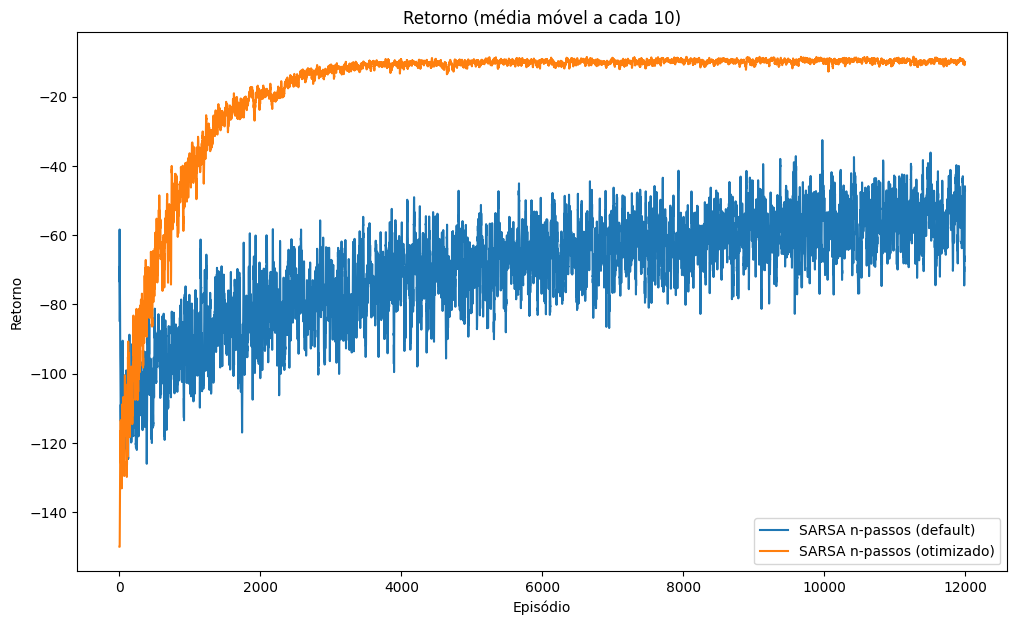

In [ ]:
#env_race = TimeLimit(RacetrackEnv(), 500)
env_race = gym.make("RaceTrack-v0")
NUM_EPISODES = 12_000
RUNS = 3

results = []

results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, env_race, NUM_EPISODES) )
#clear_output()

results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, env_race, NUM_EPISODES, **study1.best_params) )
clear_output()

plot_multiple_results(results, x_log_scale=False)

### CartPole

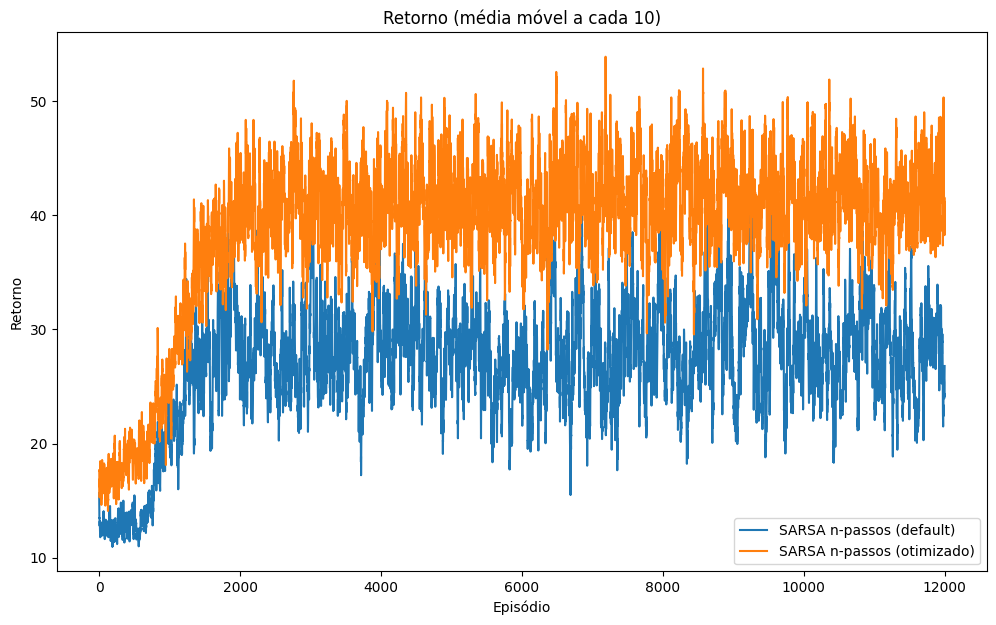

In [ ]:
env_cart = gym.make("CartPole-v1")
NUM_EPISODES = 12_000
RUNS = 3

results = []

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [30,30,30,30])
results.append( repeated_exec(RUNS, f"SARSA n-passos (default)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, auto_load=True) )
#clear_output()

params = study2.best_params

wrapped_env_cart = ObservationDiscretizerWrapper(env_cart, [ params['bins1'], params['bins2'], params['bins3'], params['bins4'] ] )
results.append( repeated_exec(RUNS, f"SARSA n-passos (otimizado)", run_nstep_sarsa, wrapped_env_cart, NUM_EPISODES, epsilon=params['epsilon'], lr=params['lr'], nsteps=params['nsteps'], auto_load=True) )
clear_output()

plot_multiple_results(results, x_log_scale=False)